# Graphics using Seaborn

We previously have covered how to do some basic graphics using `matplotlib`. In this notebook we introduce a package called `seaborn`. `seaborn` builds on top of `matplotlib` by doing 2 things:

1. Gives us access to more types of plots (Note: Every plot created in `seaborn` could be made by `matplotlib`, but you shouldn't have to worry about doing this)
2. Sets better defaults for how the plot looks right away

_This notebook was created by Dave Backus, Chase Coleman, and Spencer Lyon for the NYU Stern course [Data Bootcamp](http://databootcamp.nyuecon.com/)._

In [158]:
import datetime as dt
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr
import requests as r
import seaborn as sns
import sys


from io import StringIO

%matplotlib inline

As per usual, we begin by listing the versions of each package that is used in this notebook.

In [159]:
# check versions (overkill, but why not?)
print('Python version:', sys.version)
print('Pandas version: ', pd.__version__)
print('Matplotlib version: ', mpl.__version__)
print('Seaborn version: ', sns.__version__)
print('Today: ', dt.date.today())

Python version: 3.5.1 |Anaconda custom (64-bit)| (default, Dec  7 2015, 11:16:01) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
Pandas version:  0.18.0
Matplotlib version:  1.5.1
Seaborn version:  0.7.0
Today:  2016-04-20


## Today's Data

Today we will use intraday data from google finance. In particular, we will download 30 second data for the most recent 5 days for several stocks.

Unless you are particularly interested in being able to do this, we suggest skipping it.

In [276]:
def retrieve_single_timeseries(ticker, secs=60, ndays=5):
    """
    Grabs data from Google finance. It retrieves the data for `ticker` at
    `secs` intervals for the most recent `ndays`. The fields it retrieves
    for each interval is (time, open price, close price, volume of trade)

    Parameters
    ----------

    Returns
    -------

    """
    # Get the Base url
    baseurl = "http://www.google.com/finance/getprices"

    # Dictionary for parameters
    pdict = {}
    pdict["q"] = ticker
    pdict["i"] = secs
    pdict["p"] = str(ndays) + "d"
#     pdict["f"] = ["d", "c", "v", "o"]
    pdict["f"] = "d,c,v,o"

    # Retrieve data
    raw_html = r.get(baseurl, params=pdict)
    raw_text = raw_html.text

    # Clean data
    data = clean_data(raw_text, ticker)

    return data

def clean_data(raw_text, ticker):
    """
    Takes the raw text output of the html request and cleans it into a
    pandas dataframe

    Parameters
    ----------
    raw_text : String
        The text generated by the html request

    Returns
    -------
    data : Pandas.DataFrame
        DataFrame with relevant data

    """
    # Split by line separators
    all_lines = raw_text.split("\n")
    metadata = all_lines[1:7]
    data_csv = StringIO("\n".join(all_lines[7:]))

    # Deal with metadata that we care about
    for line in metadata:
        if "COLUMNS=" in line:
            # Get columns
            columns = line.split("COLUMNS=")[1].split(",")
        elif "INTERVAL" in line:
            timeincrement = int(line.split("INTERVAL=")[1])
        elif "TIMEZONE_OFFSET" in line:
            # Get timezone offset in seconds
            tzoffset = int(line.split("TIMEZONE_OFFSET=")[1])*60
        elif "MARKET_OPEN_MINUTE" in line:
            opentime = ()

    # Load data into pandas
    data = pd.read_csv(data_csv, names=columns)

    # Fix the date rows
    data.insert(0, "DateTime", np.NaN)
    data.insert(1, "TICKER", ticker)
    for i, row in data.iterrows():
        if row["DATE"][0] is "a":
            secsfromepoch = int(row["DATE"][1:])
            basedate = dt.datetime.utcfromtimestamp(secsfromepoch + tzoffset)
            data.set_value(i, "DateTime", basedate)
        else:
            secsfrombase = int(row["DATE"])
            data.set_value(i, "DateTime", basedate + dt.timedelta(seconds=secsfrombase*timeincrement))
    
    # Fix the data (no price changes when market is closed)

    # Drop irrelevant info, compute incremental returns, rename, and set index
    data = data.drop(labels="DATE", axis=1)
    data = data.rename(columns={"DateTime": "DATE"})
    data.insert(1, "RETURNS", 100*(data["CLOSE"]/data["OPEN"] - 1))
#     data = data.set_index(["DATE", "TICKER"])

    return data


Run it on a single ticker to make sure that we get what we want

In [277]:
df = retrieve_single_timeseries("AAPL")
df.head()

,DATE,RETURNS,TICKER,CLOSE,OPEN,VOLUME
0,2016-04-14 09:30:00,0.026877,AAPL,111.65,111.620,291016
1,2016-04-14 09:31:00,-0.102977,AAPL,111.56,111.675,282447
2,2016-04-14 09:32:00,0.170312,AAPL,111.75,111.560,244969
3,2016-04-14 09:33:00,-0.116331,AAPL,111.62,111.750,104233
4,2016-04-14 09:34:00,0.062713,AAPL,111.69,111.620,130233


Now we can run it for a variety of tickers that we might like to see information on.

In [278]:
stock_tickers = ["AAPL", "F", "GM" ,"GOOG", "MSFT", "ADR"]
dfs = []

for tick in stock_tickers:
    dfs.append(retrieve_single_timeseries(tick))

In [302]:
data = pd.concat(dfs)
print(data.shape)
data.set_index("TICKER").loc["AAPL"].head(750).tail(5)

(11204, 6)


,DATE,RETURNS,CLOSE,OPEN,VOLUME
TICKER,,,,,
AAPL,2016-04-15 15:24:00,0.000000,109.930,109.9300,144348
AAPL,2016-04-15 15:25:00,-0.022744,109.895,109.9200,72344
AAPL,2016-04-15 15:26:00,0.000091,109.900,109.8999,35962
AAPL,2016-04-15 15:27:00,0.009100,109.900,109.8900,44250
AAPL,2016-04-15 15:28:00,0.045496,109.950,109.9000,76113


## Better Defaults

Recall that in our [previous notebook](bootcamp_graphics.ipynb) that we used `plt.style.use` to set styles. We will begin by setting the style to `"classic"`; this sets all of our default settings back to `matplotlib`'s default values.

Below we plot open and closing prices on the top axis and the implied returns on the bottom axis.

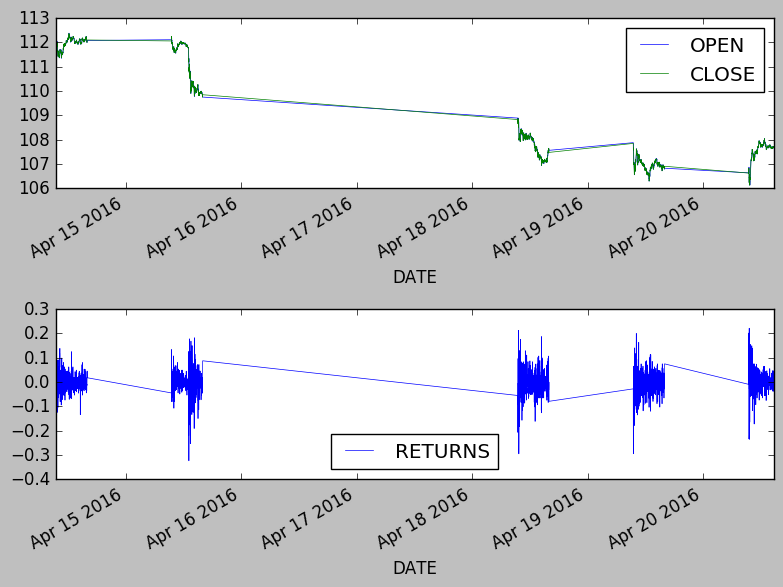

In [335]:
plt.style.use("classic")

fig, ax = plt.subplots(2)

data.set_index("TICKER").loc["AAPL"].plot(x="DATE", y="OPEN",
                                          linewidth=0.5, ax=ax[0])
data.set_index("TICKER").loc["AAPL"].plot(x="DATE", y="CLOSE",
                                          linewidth=0.5, ax=ax[0])

data.set_index("TICKER").loc["AAPL"].plot(x="DATE", y="RETURNS",
                                          linewidth=0.5, ax=ax[1])

fig.tight_layout()

# fig.savefig("/home/chase/Desktop/foo.png")

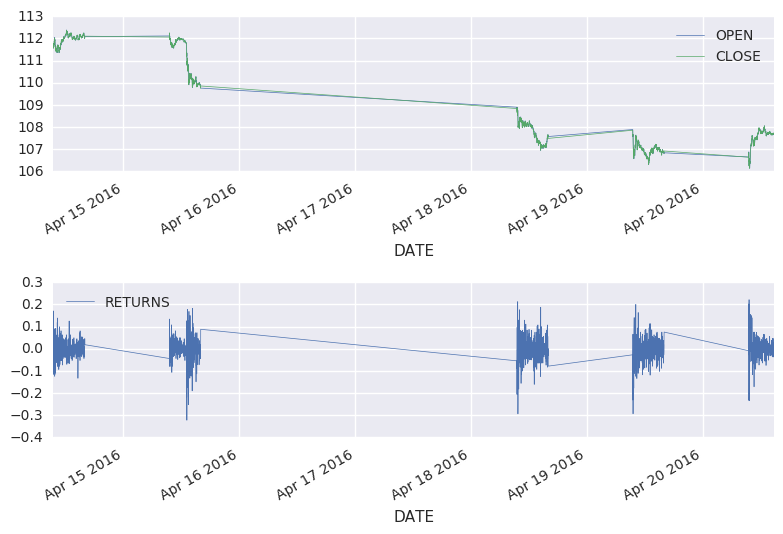

In [336]:
# sns.set() resets default seaborn settings
sns.set()

fig, ax = plt.subplots(2)

data.set_index("TICKER").loc["AAPL"].plot(x="DATE", y="OPEN",
                                          linewidth=0.5, ax=ax[0])
data.set_index("TICKER").loc["AAPL"].plot(x="DATE", y="CLOSE",
                                          linewidth=0.5, ax=ax[0])

data.set_index("TICKER").loc["AAPL"].plot(x="DATE", y="RETURNS",
                                          linewidth=0.5, ax=ax[1])

fig.tight_layout()

What did you notice about the differences in the settings of the plot?

Which do you like better? We like the second better.

Investigate other styles and create the same plot as above using a style you like. You can choose from the list in the code below.

In [339]:
plt.style.available

['seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-notebook',
 'seaborn-ticks',
 'seaborn-muted',
 'seaborn-colorblind',
 'fivethirtyeight',
 'ggplot',
 'seaborn-pastel',
 'bmh',
 'seaborn-deep',
 'seaborn-dark',
 'seaborn-bright',
 'seaborn-white',
 'seaborn-poster',
 'classic',
 'grayscale',
 'seaborn-whitegrid',
 'seaborn-talk',
 'seaborn-paper',
 'dark_background']